# Higher order Laplacians for protein atoms <a class="anchor" id="toc"></a>
Authors: Mikhail Tsitsvero

<br/>

1. [Protein 3-D point cloud of atoms](#proteins)
2. [Constructing simplex tree](#tree)
3. [Using ```HodgeLaplacinans()``` class](#hodge) 
4. [References](#refs)


<br/>

#### Abstract
In this example we will illustrate how to use ```HodgeLaplacians()``` class to get higher order Laplacians for a simplicial complex constructed from the protein data. To access Protein Data Bank we will use [BioPython Library](https://biopython.org/) and to efficiently compute the tree of simplices we will use [C++ GUDHI Library](http://gudhi.gforge.inria.fr/). A variety of alternative [libraries for Topological Data Analysis](https://en.wikipedia.org/wiki/Persistent_homology#Computation) are also available. 

<br/>
<br/>

## Protein point cloud data <a class="anchor" id="proteins"></a> [↑](#toc)
First, to install BioPython and nglview run
```python
pip3 install biopython nglview
```
To activate the nglview extension for notebook, run before starting Jupyter:
```python
jupyter-nbextension enable nglview --py --sys-prefix
jupyter nbextension enable widgetsnbextension --user --py
```

There is a [nice video tutorial](https://www.youtube.com/watch?v=mL8NPpRxgJA) ([notebook for tutorial](https://nbviewer.jupyter.org/github/cgoliver/Notebooks/blob/master/COMP_364/L27/L27.ipynb)) on BioPython and Protein Data Bank format.

In [1]:
from Bio.PDB import *
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pdbl_1 = PDBList()
pdbl_1.retrieve_pdb_file('4XP1')

pdbl_2 = PDBList()
pdbl_2.retrieve_pdb_file('3I40')

parser_1 = MMCIFParser()
parser_2 = MMCIFParser()

structure_1 = parser_1.get_structure('4XP1', 'xp/4xp1.cif')
structure_2 = parser_2.get_structure('4XP1', 'i4/3i40.cif')

Structure exists: '/workspace/hodgelaplacians/examples/xp/4xp1.cif' 
Structure exists: '/workspace/hodgelaplacians/examples/i4/3i40.cif' 


Let us visualize two proteins using the viewer form ```nglview``` module.

In [2]:
import nglview as nv

view_1 = nv.show_biopython(structure_1)
view_1.clear_representations()
#view as ball and stick (atom and bond)
view_1.add_ball_and_stick()

view_1

NGLWidget()

In [4]:
view_2 = nv.show_biopython(structure_2)
view_2.clear_representations()
#view as ball and stick (atom and bond)
view_2.add_ball_and_stick()
view_2

NGLWidget()

Next we extract the 3-D coordinates of individual atoms in each protein.

In [5]:
points_1 = []
points_2 = []

for model in structure_1:
    for chain in model:
        for residue in chain:
            for atom in residue:
                points_1.append(tuple(atom.coord))
                
for model in structure_2:
    for chain in model:
        for residue in chain:
            for atom in residue:
                points_2.append(tuple(atom.coord))

points_1 = np.array(points_1)
points_2 = np.array(points_2)

print(f"There are {len(points_1)} atoms in the protein 1.")
print(f"There are {len(points_2)} atoms in the protein 2.")

There are 7675 atoms in the protein 1.
There are 438 atoms in the protein 2.


## Constructing simplex tree <a class="anchor" id="tree"></a> [↑](#toc)

In this section we will connect the neighboring points/atoms with edges thus obtaining a graph where each node/atom is connected to its neighbours in 3D. From the graph we derive the Vietoris-Rips simplicial complex simply by adding simplices associated to each clique of up to certain size in a graph.

To get the connectivity of a graph we will use C++ GUDHI Library that will provides us simplex tree with filtration values as an output. We will use simplex tree data as input data to our ```HodgeLaplacians()``` class. 

To install GUDHI Library:
1. [Download and compile C++ Sources](http://gudhi.gforge.inria.fr/doc/latest/installation.html)
2. [Build Cython module for GUDHI](http://gudhi.gforge.inria.fr/python/latest/installation.html)

P.S. Don't forget to install all C/C++ dependencies like Boost, CGAL, Eigen, GMP, CMake,...

Let us assume that you've spent happy 30 minutes and compiled and installed the library, so we can proceed with the construction of connectivity and simplex tree to finally feed it into ```HodgeLaplacians()``` class.

Construction of local neighbourhood connectivity is computationally intensive task that is why we rely on a separate compiled C++ library and do not incorporate this functionality inside ```HodgeLaplacians()``` class. In Python pairwise distance check for points could take a long time.

In [11]:
import gudhi as gd
import time
start_time = time.time()


epsilon = 3 # Connect two points if distance is smaller than epsilon

skeleton_1  = gd.RipsComplex(points = points_1, max_edge_length=epsilon )
rips_simplex_tree_1 = skeleton_1.create_simplex_tree(max_dimension=3) 
rips_skeleton_gudhi_1 = rips_simplex_tree_1.get_skeleton(3)

skeleton_2  = gd.RipsComplex(points = points_2, max_edge_length=epsilon )
rips_simplex_tree_2 = skeleton_2.create_simplex_tree(max_dimension=3) 
rips_skeleton_gudhi_2 = rips_simplex_tree_2.get_skeleton(3)

end_time = time.time()

print(f"Simplex tree constructed in {end_time-start_time} seconds")

Simplex tree constructed in 1.1395461559295654 seconds


## Using ```HodgeLaplacinans()``` to get diffusion operators, Ricci curvature and spectrum <a class="anchor" id="hodge"></a>

To install ```hodgelaplacians``` library 
~~~
pip3 install hodgelaplacians
~~~


First let us import the main class ```HodgeLaplacians()```, initialize it by simplex tree, and get all the Laplacian matrices and boundary maps for both proteins.

In [12]:
import sys
sys.path.insert(0, "../")
from hodgelaplacians import HodgeLaplacians

start = time.time()

hl_1 = HodgeLaplacians(rips_skeleton_gudhi_1, maxdimension=3, mode='gudhi')
hl_2 = HodgeLaplacians(rips_skeleton_gudhi_2, maxdimension=3, mode='gudhi')

In [13]:
print(f"There are {len(hl_1.n_faces(0))} 0-simplices (atoms) in simplicial complex of protein 1")
print(f"There are {len(hl_1.n_faces(1))} 1-simplices (edges) in simplicial complex of protein 1")
print(f"There are {len(hl_1.n_faces(2))} 2-simplices (faces) in simplicial complex of protein 1 \n")

print(f"There are {len(hl_2.n_faces(0))} 0-simplices (atoms) in simplicial complex of protein 2")
print(f"There are {len(hl_2.n_faces(1))} 1-simplices (edges) in simplicial complex of protein 2")
print(f"There are {len(hl_2.n_faces(2))} 2-simplices (faces) in simplicial complex of protein 2 \n")

There are 7675 0-simplices (atoms) in simplicial complex of protein 1
There are 23469 1-simplices (edges) in simplicial complex of protein 1
There are 23924 2-simplices (faces) in simplicial complex of protein 1 

There are 438 0-simplices (atoms) in simplicial complex of protein 2
There are 1230 1-simplices (edges) in simplicial complex of protein 2
There are 1189 2-simplices (faces) in simplicial complex of protein 2 



In [14]:
start = time.time()

# # Boundary operators
B0_1 = hl_1.getBoundaryOperator(0)
B1_1 = hl_1.getBoundaryOperator(1)
B2_1 = hl_1.getBoundaryOperator(2)
B3_1 = hl_1.getBoundaryOperator(3)

# # Hodge Laplacians
L0_1 = hl_1.getHodgeLaplacian(0)
L1_1 = hl_1.getHodgeLaplacian(1)
L2_1 = hl_1.getHodgeLaplacian(2)
L3_1 = hl_1.getHodgeLaplacian(3)

# # Bochner Laplacian 
# # (row sum of absolute values equals to diagonal element)
LB0_1 = hl_1.getBochnerLaplacian(0)
LB1_1 = hl_1.getBochnerLaplacian(1)
LB2_1 = hl_1.getBochnerLaplacian(2)
LB3_1 = hl_1.getBochnerLaplacian(3)
end = time.time()

print(f"Laplacians for protein 1 were constructed in {end-start} seconds")

Laplacians for protein 1 were constructed in 2.5004234313964844 seconds


Let us see how many simplices of each dimension are there for each protein

In [15]:
start = time.time()

# # Boundary operators
B0_2 = hl_2.getBoundaryOperator(0)
B1_2 = hl_2.getBoundaryOperator(1)
B2_2 = hl_2.getBoundaryOperator(2)
B3_2 = hl_2.getBoundaryOperator(3)

# # Hodge Laplacians
L0_2 = hl_2.getHodgeLaplacian(0)
L1_2 = hl_2.getHodgeLaplacian(1)
L2_2 = hl_2.getHodgeLaplacian(2)
L3_2 = hl_2.getHodgeLaplacian(3)

# # Bochner Laplacian 
# # (row sum of absolute values equals to diagonal element)
LB0_2 = hl_2.getBochnerLaplacian(0)
LB1_2 = hl_2.getBochnerLaplacian(1)
LB2_2 = hl_2.getBochnerLaplacian(2)
LB3_2 = hl_2.getBochnerLaplacian(3)
end = time.time()

print(f"Laplacians for protein 2 were constructed in {end-start} seconds")

Laplacians for protein 2 were constructed in 0.13333988189697266 seconds


## Simulate higher-order diffusion

In this section we will get heat kernels for Hodge and Bochner Laplacians. Heat kernel is the fundamental solution of the heat equation. Denoting by $L$ a Laplacian operator, heat equation is given by $$\partial_t f = L f$$ and the heat kernel its fundamental solution at time $t$ $$G = e^{tL}.$$

In [ ]:
    def getHodgeHeatKernel(self,d,t):



    def getBochnerHeatKernel(self,d,t):


    def diffuseChainHodge(self, d, chain, t):


    def diffuseChainBochner(self, d, chain, t):


### Hodge and Bochner Laplacian eigenvalues in an interval

Computation of eigenvalue/eigenvector parir is an expensive operation. ```HodgeLaplacians()``` class uses  ARPACK algorithm from ```scipy.sparse``` module to perform this task. Let us illustrate how it works in practice and measure timing.

Let us compute the first 20 eigenvalue/eigenvector pairs. For the protein 1 which has more atoms it should take longer (estimated around 100 seconds).

In [17]:
start = time.time()

evalsL1_1, evecsL1_1 = hl_1.getHodgeSpectrum(1, 10, around_point = 0.01)
evalsLB1_1, evecsLB1_1 = hl_1.getBochnerSpectrum(1, 10, around_point = 0.01)

end = time.time()
print(f"Eigendecomposition is performed in {end - start} seconds for protein 1.")

Eigendecomposition is performed in 5.943233966827393 seconds for protein 1.


Protein 2 is smaller. Let us time eigendecomposition of its 1-Laplacians.

In [18]:
start = time.time()

evalsL1_2, evecsL1_2 = hl_2.getHodgeSpectrum(1, 10, around_point = 0.01)
evalsLB1_2, evecsLB1_2 = hl_2.getBochnerSpectrum(1, 10, around_point = 0.01)

end = time.time()
print(f"Eigendecomposition is performed in {end - start} seconds for protein 2.")

Eigendecomposition is performed in 14.773340940475464 seconds for protein 2.


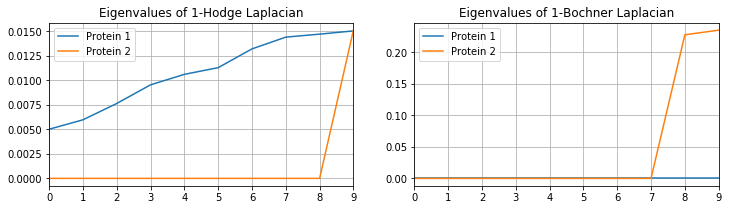

In [19]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

df = pd.DataFrame({'Protein 1':evalsL1_1, 'Protein 2':evalsL1_2})
df[['Protein 1', 'Protein 2']].plot(ax=axes[0], title="Eigenvalues of 1-Hodge Laplacian", grid=True)

df = pd.DataFrame({'Protein 1':evalsLB1_1, 'Protein 2':evalsLB1_2})
df[['Protein 1', 'Protein 2']].plot(ax=axes[1], title="Eigenvalues of 1-Bochner Laplacian", grid=True)

### Distribution of combinatorial Ricci curvature of two proteins

Combinatorial Ricci curvature utilizes Bochner decomposition identity to obtain diagonal Ricci curvature matrix and was introduced by R. Formain in [[1](#refs)] or just [click here](https://link.springer.com/content/pdf/10.1007%2Fs00454-002-0743-x.pdf) to access the pdf directly.

In [20]:
# Combinatorial Ricci curvature
# (correction term for Laplacian to become Bochner Laplacian)
R0_1 = hl_1.getCombinatorialRicci(0)
R1_1 = hl_1.getCombinatorialRicci(1)
R2_1 = hl_1.getCombinatorialRicci(2)
R3_1 = hl_1.getCombinatorialRicci(3)

# # Combinatorial Ricci curvature
# # (correction term for Laplacian to become Bochner Laplacian)
R0_2 = hl_2.getCombinatorialRicci(0)
R1_2 = hl_2.getCombinatorialRicci(1)
R2_2 = hl_2.getCombinatorialRicci(2)
R3_2 = hl_2.getCombinatorialRicci(3)

Now let us plot the historgrams side-by-side

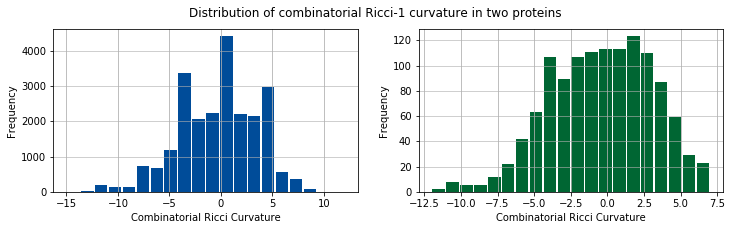

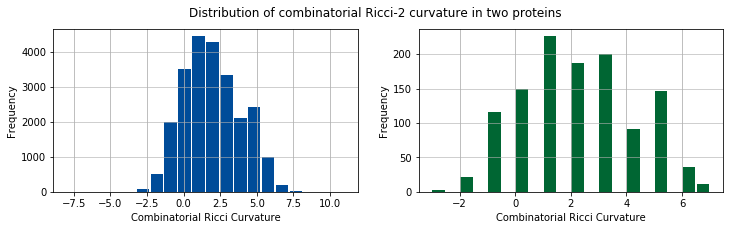

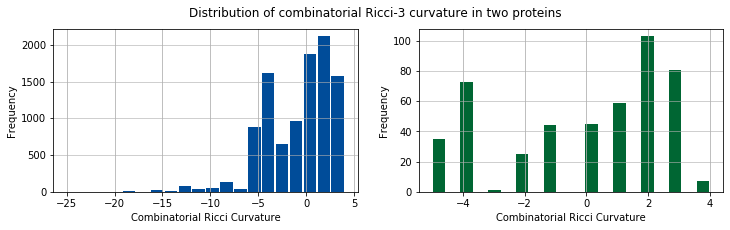

In [21]:
plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
plt.suptitle('Distribution of combinatorial Ricci-1 curvature in two proteins \n')
plt.xlabel('Combinatorial Ricci Curvature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plot_ricci1_1 = pd.Series(R1_1)
plot_ricci1_1.plot.hist(grid=True, bins=20, rwidth=0.9, color='#004c99')
plt.subplot(1, 2, 2)
plt.xlabel('Combinatorial Ricci Curvature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plot_ricci1_2 = pd.Series(R1_2)
plot_ricci1_2.plot.hist(grid=True, bins=20, rwidth=0.9, color='#006633')


plt.figure(figsize=(12,3))
plt.suptitle('Distribution of combinatorial Ricci-2 curvature in two proteins \n')
plt.subplot(1, 2, 1)
plt.xlabel('Combinatorial Ricci Curvature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plot_ricci1_1 = pd.Series(R2_1)
plot_ricci1_1.plot.hist(grid=True, bins=20, rwidth=0.9, color='#004c99')
plt.subplot(1, 2, 2)
plt.xlabel('Combinatorial Ricci Curvature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plot_ricci1_2 = pd.Series(R2_2)
plot_ricci1_2.plot.hist(grid=True, bins=20, rwidth=0.9, color='#006633')


plt.figure(figsize=(12,3))
plt.suptitle('Distribution of combinatorial Ricci-3 curvature in two proteins \n')
plt.subplot(1, 2, 1)
plt.xlabel('Combinatorial Ricci Curvature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plot_ricci1_1 = pd.Series(R3_1)
plot_ricci1_1.plot.hist(grid=True, bins=20, rwidth=0.9, color='#004c99')
plt.subplot(1, 2, 2)
plt.xlabel('Combinatorial Ricci Curvature')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plot_ricci1_2 = pd.Series(R3_2)
plot_ricci1_2.plot.hist(grid=True, bins=20, rwidth=0.9, color='#006633')

## References <a class="anchor" id="refs"></a> [↑](#toc)

1. [R. Forman, Bochner's Method for Cell Complexes and Combinatorial Ricci Curvature](https://link.springer.com/content/pdf/10.1007%2Fs00454-002-0743-x.pdf)